# final version of the  Mage(multi agent genetic evolution)



---

# **MAGE: A Multi-Agent Genetic Evolution Framework for Neural Architecture Optimization**

---

## **Abstract**

The **MAGE (Multi-Agent Genetic Evolution)** algorithm is a neural network optimization framework that merges evolutionary computation with adaptive randomness to evolve architectures, weights, and hyperparameters simultaneously.
Initially designed as a lightweight self-evolving trainer, MAGE now integrates two distinct search paradigms — *Single-Architecture Evolution* and *Multi-Architecture Exploration* — allowing flexible behavior depending on research goals.
Unlike classical Neuroevolution or NAS methods that rely on complex graph search, MAGE operates on compact genetic representations of neural networks, promoting *diversity through randomness* and *stability through fitness control*.
This paper presents the conceptual foundation, system architecture, mathematical formulation, pseudocode, and implementation flow of MAGE.

---

## **1. Introduction**

Neural network optimization traditionally depends on gradient descent methods tuned by human-engineered architectures and learning rates. However, such manual tuning limits scalability and adaptability.

**MAGE** was conceived to automate this process using a population-based evolutionary framework where each *agent* represents an independent neural model with its own parameters, architecture, and hyperparameters. These agents evolve collectively — learning locally, competing globally, and mutating based on performance.

The initial design of MAGE focused purely on *randomness-based self-organization*, inspired by population diversity in natural systems. The randomness was the engine of discovery — agents began with random weights, random architectures, and minimal rules. However, this produced instability at scale.

The modern form of MAGE introduces **controlled randomness**, **adaptive mutation**, and **search modes** (single and multi) to ensure both stability and exploratory capacity. This paper formalizes that final design.

---

## **2. Evolution of the MAGE Concept**

| Generation | Core Idea                                                | Limitation                           | Resulting Evolution                          |
| ---------- | -------------------------------------------------------- | ------------------------------------ | -------------------------------------------- |
| MAGE v1    | Random weight diversification per agent                  | High variance, unstable training     | Introduced noise control                     |
| MAGE v2    | Added mutation control for hyperparams                   | Lack of structure search             | Introduced architecture mutation             |
| MAGE v3    | Added search modes: *single* and *multi*                 | Needed deterministic reproducibility | Added controlled randomness (seed-based RNG) |
| Final MAGE | Unified architecture + hyperparameter + weight evolution | None (stable and research-ready)     | Current class design                         |

Thus, MAGE evolved from a random experimentation framework to a structured evolutionary system combining **determinism, exploration, and self-adaptation**.

---

## **3. Core Architecture of the MAGE Class**

### **3.1 Class Overview**

Each instance of `MAGE` represents an *evolutionary trainer* with:

* **Population of agents:** Each agent is a neural network defined by architecture, weights, and hyperparameters.
* **Fitness function:** Validation loss (val_loss) determines evolutionary fitness.
* **Evolutionary loop:** Repeated selection, mutation, and replacement across master epochs.

### **3.2 Core Components**

| Component                                                              | Description                                                            |
| ---------------------------------------------------------------------- | ---------------------------------------------------------------------- |
| `__init__()`                                                           | Initializes search settings, noise factors, and RNG.                   |
| `fit()`                                                                | Performs evolution loop combining local learning and global selection. |
| `_train_agent_local()`                                                 | Trains a single agent locally using standard backpropagation.          |
| `_fitness()`                                                           | Computes validation loss + complexity penalty.                         |
| `_mutate_weights()`, `_mutate_hyperparams()`, `_mutate_architecture()` | Apply stochastic transformations to agents.                            |
| `get_execution_details()`                                              | Logs evolution history for research analysis.                          |
| `evaluate()`                                                           | Evaluates best-evolved agent on test data.                             |

---

## **4. Algorithm Workflow**

### **4.1 Population Initialization**

Each agent begins as:
[
A_i = {W_i, B_i, arch_i, hp_i}
]
where:

* (W_i, B_i) = weight and bias matrices
* (arch_i = {layers, activations})
* (hp_i = {lr, batch, optimizer, weight_decay})

Two modes exist:

* **Single Mode:** All agents share *same architecture*, different weights/hyperparameters.
* **Multi Mode:** Each agent starts with *different architecture* from `search_space`.

---

### **4.2 Local Learning (Within Master Epoch)**

Each agent trains for a few `local_epochs` using its own hyperparameters.

Pseudocode:

```python
for agent in population:
    agent.train(X_train, y_train, epochs=local_epochs)
    agent.val_loss = evaluate(agent, X_val, y_val)
```

This produces per-agent `val_loss` values used for selection.

---

### **4.3 Global Selection & Fitness Computation**

Fitness is inversely proportional to performance:
[
F_i = ValLoss_i + \lambda \cdot Complexity(arch_i)
]
Lower fitness is better.

Agents are sorted by fitness; elites (top N) are preserved for next generation.

---

### **4.4 Mutation and Controlled Randomness**

For each non-elite agent:

1. Select parent with better fitness.
2. Create child copy or random agent (depending on search mode).
3. Apply probabilistic mutations:

[
p_{mutate} = base_prob \times rank_factor
]

The **rank factor** (between 1.0 and 0.3) ensures *stronger agents mutate less, weaker agents mutate more*, maintaining diversity.

---

### **4.5 Controlled Randomness (Deterministic RNG)**

MAGE introduces deterministic randomness by:

```python
self.rng = np.random.default_rng(seed)
```

and uses it consistently across weight initialization, architecture mutation, and hyperparameter evolution.

This ensures repeatability while maintaining diversity.

---

## **5. Search Modes**

### **5.1 Single Mode**

* Architecture: fixed by user.
* Variation: only through weights and hyperparameters.
* Purpose: evaluate optimization strategies without structural search.
* Example:

  ```python
  search_mode="single"
  search_space={"layers": [[784, 128, 10]], "activations": ["relu"]}
  ```

Lifecycle:

1. All agents start with same `[784,128,10]`.
2. Each agent trains independently.
3. Best weights evolve through mutation and selection.

### **5.2 Multi Mode**

* Architecture: sampled from `search_space`.
* Each agent evolves both structure and parameters.
* Used for *Neural Architecture Search (NAS)*-like behavior.
* Example:

  ```python
  search_mode="multi"
  search_space={
      "layers": [[64,128,64],[128,64],[256,128,64],[512,256]],
      "activations": ["relu","tanh","gelu"]
  }
  ```

Lifecycle:

1. Different architectures initialized per agent.
2. Training + evaluation performed per structure.
3. Best-performing architectures and hyperparameters survive.
4. Mutations can add/remove layers, neurons, or activations.

---

## **6. Evolutionary Loop Summary**

Pseudocode Summary:

```python
Initialize population (single or multi)
for each master_epoch:
    Train each agent locally
    Evaluate validation loss (val_loss)
    Select top elite agents
    Mutate and reproduce remaining agents
    Update controlled randomness
Save best architecture and weights
```

---

## **7. Validation Loss Lifecycle**

* Computed after each local training loop:
  [
  val_loss = L(f(X_{val};W,B), y_{val})
  ]
* Stored in agent dict and used to compute fitness.
* Drives selection pressure — agents with lower val_loss survive.
* In `get_execution_details()`, logged per master epoch for analysis.

In **single mode**, val_loss tracks how different hyperparameters impact same architecture.
In **multi mode**, val_loss additionally measures *architectural fitness*.

---

## **8. Experimental Observations**

| Mode   | Objective                    | Expected Behavior                                         |
| ------ | ---------------------------- | --------------------------------------------------------- |
| Single | Optimize one given structure | Finds best weights/lr faster, stable val_loss convergence |
| Multi  | Explore architectures        | Slower convergence but more global minima exploration     |
| Both   | Complementary                | Combine to fine-tune architecture post exploration        |

---

## **9. Key Features Making MAGE Research-Ready**

1. **Deterministic RNG:** Reproducible randomness.
2. **Controlled Mutation Scaling:** Based on agent rank.
3. **Dual-Mode Search:** Single (fixed) vs Multi (exploratory).
4. **CSV Logging:** Enables full traceability of each agent’s evolution.
5. **Architecture & Hyperparam Integration:** Unified evolutionary process.
6. **Complexity-Aware Fitness:** Penalizes overly large models.
7. **Self-contained Python Implementation:** No dependency on heavy NAS frameworks.

---

## **10. Example Result Interpretation (CSV Log)**

Example Row:

```python
3,0,0.265,101770,"[784,128,10]",['relu'],0.0009,128
```

Meaning:

* Epoch 3, Agent 0
* Validation Loss = 0.265
* Parameter Count = 101,770
* Architecture = [784,128,10]
* Activation = relu
* Learning Rate = 0.0009
* Batch Size = 128

This row represents one agent’s final status after training and selection for a given master epoch.

---

## **11. Conclusion**

MAGE represents a minimal yet complete **evolutionary intelligence system** that autonomously explores, evaluates, and optimizes neural architectures and hyperparameters. Its design balances *stochastic exploration* with *deterministic reproducibility*, making it suitable for research on evolutionary deep learning, NAS, and adaptive optimization.

The dual-mode framework enables both **deep optimization (single)** and **broad exploration (multi)** — making MAGE a scalable foundation for future agentic AI research.

---

## **12. Future Directions**

* Integrate **self-adaptive learning rates** per agent.
* Add **crossover mechanism** for hybrid offspring generation.
* Implement **parallel execution** across CPU/GPU nodes.
* Extend **fitness** to multi-objective (accuracy, latency, energy).

---

## **Appendix: Pseudocode of the MAGE Algorithm**

```python
Initialize population of N agents
for master_epoch in range(M):
    for each agent:
        train locally for local_epochs
        compute val_loss
    rank agents by fitness (val_loss + complexity)
    select top elites
    for each non-elite agent:
        if mode == "multi":
            mutate architecture
        mutate weights and hyperparams
        apply controlled randomness
    replace old population
return best agent
```

---




In [1]:
# mage_with_arch_hp_research_ready.py
import os
import json
import csv
import pickle
import random
import numpy as np
from typing import List, Dict, Any, Tuple

# deterministic seeds for interpreter-level sources (keeps file-level reproducible behavior)
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)

# ---------------- basic activations & utils ----------------
def relu(x): return np.maximum(0, x)
def relu_deriv(z): return (z > 0).astype(z.dtype)
def tanh(x): return np.tanh(x)
def tanh_deriv(z): return 1.0 - np.tanh(z)**2
def sigmoid(x):
    x = np.clip(x, -50., 50.)
    return 1.0 / (1.0 + np.exp(-x))
def sigmoid_deriv(z):
    s = sigmoid(z)
    return s * (1 - s)

def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=1, keepdims=True)

_ACT_FNS = {
    "relu": (relu, relu_deriv),
    "tanh": (tanh, tanh_deriv),
    "sigmoid": (sigmoid, sigmoid_deriv),
}

def glorot_uniform(shape, rng: np.random.RandomState):
    fan_in, fan_out = int(shape[0]), int(shape[1])
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return rng.uniform(-limit, limit, size=shape).astype(np.float32)

def one_hot(y, n_classes):
    y = np.asarray(y, dtype=int).reshape(-1)
    oh = np.zeros((y.shape[0], n_classes), dtype=np.float32)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

# ---------------------- MAGE with arch+hp evolution ------------------------
class MAGE:
    """
    Competitive Mode (Balanced) MAGE:
     - deterministic master RNG (np.random.RandomState)
     - per-agent RNG derived from master RNG
     - controlled randomness during reproduction (rank-based scaling)
     - architecture + hyperparam + weight mutations
     - NTK & complexity proxy in fitness
    """
    def __init__(self,
                 input_dim:int,
                 output_dim:int,
                 task="multiclass",
                 initial_hidden=[128],
                 num_agents=6,
                 seed=42,
                 base_noise=0.01,
                 mutation_type="hybrid",
                 evolution_mode="tournament",
                 elite_count=1,
                 stagnation_patience=3,
                 noise_increase_factor=2.0,
                 noise_decay_factor=0.5,
                 complexity_lambda=1e-4,
                 optimizer="adam",
                 init__weights=None,
                 mutation_probs=None,
                 search_mode="single",
                 search_space=None):
        assert task in ("regression", "binary", "multiclass")
        self.version = "MAGE version-v1.0 (research-ready, mode=C)"
        self.task = task
        self.search_mode = search_mode
        self.search_space = search_space
        self.num_agents = int(num_agents)
        self.base_noise = float(base_noise)
        self.mutation_type = mutation_type
        self.evolution_mode = evolution_mode
        self.elite_count = int(elite_count)
        self.seed = int(seed)
        # master RNG (RandomState for reproducible integer behavior)
        self.rng = np.random.RandomState(self.seed)
        self.input_dim = int(input_dim)
        self.output_dim = int(output_dim)
        self.stagnation_patience = int(stagnation_patience)
        self.noise_increase_factor = float(noise_increase_factor)
        self.noise_decay_factor = float(noise_decay_factor)
        self.current_noise = self.base_noise
        self.best_history_val = np.inf
        self.no_improve_count = 0
        self.mutation_probs = mutation_probs
        if self.mutation_probs is None:
            # sensible defaults
            self.mutation_probs = {
                "add_layer": 0.05,
                "remove_layer": 0.02,
                "add_neuron": 0.15,
                "remove_neuron": 0.10,
                "mutate_act": 0.10,
                "hp_mutate": 0.25,
                "weight_mutate": 0.4
            }
        self.arch_archive = set()
        self.best_overall = None
        self.best_overall_fitness = float("inf")
        self.history = {"epoch": [], "agent_val_losses": [], "agent_train_losses": []}
        self.complexity_lambda = float(complexity_lambda)
        self.optimizer = optimizer

        # keep config log for reproducibility
        self.config_log = {
            "version": self.version,
            "seed": self.seed,
            "num_agents": self.num_agents,
            "search_mode": self.search_mode,
            "search_space": self.search_space,
            "mutation_probs": self.mutation_probs
        }

        # scaled weights (original feature preserved)
        if init__weights is None:
            self.scaled_weights = [1] * self.num_agents
        else:
            self.scaled_weights = list(init__weights)
            self.num_agents = len(self.scaled_weights)

        # hp defaults
        self.hp_default = {
            "lr": (1e-4, 1e-2),
            "batch": (32, 128),
            "opt": ["sgd", "adam", "rmsprop"],
            "weight_decay": (0.0, 1e-4)
        }

        # construct initial population
        self.population = []
        for i in range(self.num_agents):
            if self.search_mode == "single":
                arch = {"layers": [self.input_dim] + list(initial_hidden) + [self.output_dim],
                        "acts": self._init_acts(len(initial_hidden))}
                hp = self._sample_initial_hp()
                W, B = self._init_weights_from_arch(arch)
                scale = self.scaled_weights[i]
                for l in range(len(W)):
                    W[l] *= scale
                    B[l] *= scale
                agent_seed = int(self.rng.randint(0, 2**31 - 1))
                agent_rng = np.random.RandomState(agent_seed)
                agent = {
                    "arch": arch,
                    "hp": hp,
                    "W": W,
                    "B": B,
                    "val_loss": np.inf,
                    "params": self._count_params(arch),
                    "rng": agent_rng,
                    "mutation_log": []
                }
            else:
                agent = self.random_agent()
            self.population.append(agent)

        # placeholder for NTK batch (set in fit)
        self.ntk_batch = None

        # initialize global weights from population[0] safely
        self.global_weights = [w.copy() for w in self.population[0]["W"]]
        self.global_biases = [b.copy() for b in self.population[0]["B"]]

    # ---------- helpers ----------
    def _init_acts(self, n_hidden):
        return ["relu"] * n_hidden

    def _sample_initial_hp(self):
        lr = float(np.exp(self.rng.uniform(np.log(self.hp_default["lr"][0] + 1e-12),
                                           np.log(self.hp_default["lr"][1] + 1e-12))))
        batch = int(self.rng.choice([32, 64, 128]))
        opt = self.rng.choice(self.hp_default["opt"])
        wd = float(self.rng.uniform(self.hp_default["weight_decay"][0], self.hp_default["weight_decay"][1]))
        return {"lr": lr, "batch": batch, "opt": opt, "weight_decay": wd}

    def _count_params(self, arch):
        s = 0
        L = len(arch["layers"]) - 1
        for l in range(L):
            s += arch["layers"][l] * arch["layers"][l + 1]
            s += arch["layers"][l + 1]
        return s

    def _init_weights_from_arch(self, arch):
        L = len(arch["layers"]) - 1
        W = []
        B = []
        for i in range(L):
            Wi = glorot_uniform((arch["layers"][i], arch["layers"][i+1]), self.rng)
            Bi = np.zeros((1, arch["layers"][i+1]), dtype=np.float32)
            W.append(Wi)
            B.append(Bi)
        return W, B

    def _clip_params(self, W, B, limit=3.0):
        for i in range(len(W)):
            np.clip(W[i], -limit, limit, out=W[i])
            np.clip(B[i], -limit, limit, out=B[i])

    # ---------- random agent (safe handling of variable-length lists) ----------
    def random_agent(self):
        """
        Build a single random agent using self.search_space (if provided)
        """
        agent_seed = int(self.rng.randint(0, 2**31 - 1))
        rng = np.random.RandomState(agent_seed)
        ss = self.search_space or {}

        # layer choices: accept flat ints or lists-of-ints
        layers_choices = ss.get("layers", [[128], [64, 64], [256, 128, 64]])
        # ensure each choice is a list
        processed_layers = []
        for item in layers_choices:
            if isinstance(item, int):
                processed_layers.append([int(item)])
            elif isinstance(item, (list, tuple)):
                processed_layers.append([int(x) for x in item])
            else:
                # skip invalid entries
                continue
        if len(processed_layers) == 0:
            processed_layers = [[128]]
        layers_choices = processed_layers

        activations = ss.get("activations", list(_ACT_FNS.keys()))
        activations = [a for a in activations if a in _ACT_FNS]
        if len(activations) == 0:
            activations = ["relu"]

        batch_sizes = ss.get("batch_sizes", [32, 64, 128])
        if not isinstance(batch_sizes, (list, tuple)):
            batch_sizes = [int(batch_sizes)]

        optimizers = ss.get("optimizers", ["adam", "sgd", "rmsprop"])
        lr_range = ss.get("lr_range", [1e-4, 1e-3, 1e-2])

        # sample lr
        if isinstance(lr_range, (list, tuple)) and len(lr_range) == 2 and all(isinstance(x, (int, float)) for x in lr_range):
            lr = float(np.exp(rng.uniform(np.log(lr_range[0] + 1e-12), np.log(lr_range[1] + 1e-12))))
        else:
            lr = float(rng.choice(list(lr_range)))

        # pick a layers choice by index (safe for jagged lists)
        idx = int(rng.randint(0, len(layers_choices)))
        hidden = list(layers_choices[idx])

        layers = [self.input_dim] + hidden + [self.output_dim]
        acts = [rng.choice(activations) for _ in range(len(hidden))]

        arch = {"layers": layers, "acts": acts}
        hp = {
            "lr": lr,
            "batch": int(rng.choice(batch_sizes)),
            "opt": rng.choice(optimizers),
            "weight_decay": float(rng.uniform(0.0, 1e-4))
        }

        W, B = self._init_weights_from_arch(arch)
        agent = {
            "arch": arch,
            "hp": hp,
            "W": W,
            "B": B,
            "val_loss": np.inf,
            "params": self._count_params(arch),
            "rng": rng,
            "mutation_log": []
        }
        return agent

    # ---------- forward & loss ----------
    def _forward(self, X, W, B, act_fns):
        a = X
        acts = [a]
        pre = []
        L = len(W)
        for i in range(L-1):
            z = a.dot(W[i]) + B[i]
            pre.append(z)
            a = act_fns[i](z)
            acts.append(a)
        z_out = a.dot(W[-1]) + B[-1]
        return acts, pre, z_out

    def _loss_and_grad_out(self, z, y):
        if self.task == "regression":
            diff = z - y
            return np.mean(diff*diff), (2.0 * diff) / z.shape[0]
        elif self.task == "binary":
            p = 1 / (1 + np.exp(-z))

    # compute log(p) and log(1-p) safely AS SEPARATE VARIABLES
            eps = 1e-9
            log_p = np.log(np.clip(p, eps, 1 - eps))
            log_1_p = np.log(np.clip(1 - p, eps, 1 - eps))

            loss = -np.mean(y * log_p + (1 - y) * log_1_p)
            grad = (p - y) / z.shape[0]
            return loss, grad
        else:
            p = softmax(z)
            p = np.clip(p, 1e-9, 1-1e-9)
            return -np.mean(np.sum(y*np.log(p), axis=1)), (p-y)/z.shape[0]

    # ---------- local training ----------
    def _train_agent_local(self, agent, X, y, X_val=None, y_val=None, epochs=1):
        W = agent["W"]
        B = agent["B"]
        arch = agent["arch"]
        acts = [_ACT_FNS[a][0] for a in arch["acts"]]
        act_derivs = [_ACT_FNS[a][1] for a in arch["acts"]]
        lr = float(agent["hp"].get("lr", 1e-3))
        batch = int(agent["hp"].get("batch", 32))
        optimizer = agent["hp"].get("opt", "adam")
        N = X.shape[0]
        train_loss_list = []
        rng_local = agent.get("rng", self.rng)

        # simple per-agent adam state
        opt_state_W = [{"m": np.zeros_like(W[l]), "v": np.zeros_like(W[l])} for l in range(len(W))]
        opt_state_B = [{"m": np.zeros_like(B[l]), "v": np.zeros_like(B[l])} for l in range(len(B))]
        beta1, beta2, eps = 0.9, 0.999, 1e-8
        t = 1

        for _ in range(epochs):
            idx = rng_local.permutation(N)
            for s in range(0, N, batch):
                xb = X[idx[s:s+batch]]
                yb = y[idx[s:s+batch]]

                acts_out, pre, z = self._forward(xb, W, B, acts)
                loss, dA = self._loss_and_grad_out(z, yb)
                train_loss_list.append(float(loss))

                L = len(W)
                for l in reversed(range(L)):
                    A_prev = acts_out[l]
                    if l == L-1:
                        dW = A_prev.T @ dA
                        db = np.sum(dA, axis=0, keepdims=True)
                        dA = dA @ W[l].T
                    else:
                        dZ = dA * act_derivs[l](pre[l])
                        dW = A_prev.T @ dZ
                        db = np.sum(dZ, axis=0, keepdims=True)
                        dA = dZ @ W[l].T

                    # gradient clipping
                    gnorm = np.linalg.norm(dW)
                    if gnorm > 5:
                        dW *= (5.0 / gnorm)

                    # simple optimizers
                    if optimizer == "sgd":
                        W[l] -= lr * dW
                        B[l] -= lr * db
                    else:  # adam
                        opt_state_W[l]["m"] = beta1 * opt_state_W[l]["m"] + (1 - beta1) * dW
                        opt_state_W[l]["v"] = beta2 * opt_state_W[l]["v"] + (1 - beta2) * (dW ** 2)
                        m_hat_W = opt_state_W[l]["m"] / (1 - beta1 ** t)
                        v_hat_W = opt_state_W[l]["v"] / (1 - beta2 ** t)
                        W[l] -= lr * m_hat_W / (np.sqrt(v_hat_W) + eps)

                        opt_state_B[l]["m"] = beta1 * opt_state_B[l]["m"] + (1 - beta1) * db
                        opt_state_B[l]["v"] = beta2 * opt_state_B[l]["v"] + (1 - beta2) * (db ** 2)
                        m_hat_B = opt_state_B[l]["m"] / (1 - beta1 ** t)
                        v_hat_B = opt_state_B[l]["v"] / (1 - beta2 ** t)
                        B[l] -= lr * m_hat_B / (np.sqrt(v_hat_B) + eps)
                t += 1

            # per-epoch lr decay
            lr_decay = agent["hp"].get("lr_decay", 0.97)
            agent["hp"]["lr"] = float(agent["hp"].get("lr", lr) * lr_decay)

        # weight decay
        wd = float(agent["hp"].get("weight_decay", 0.0))
        if wd and wd > 0.0:
            for l in range(len(W)):
                W[l] -= agent["hp"]["lr"] * wd * W[l]
                B[l] -= agent["hp"]["lr"] * (wd * 0.1) * B[l]

        self._clip_params(W, B)

        # validation
        if X_val is not None:
            _, _, z_val = self._forward(X_val, W, B, acts)
            val_loss, _ = self._loss_and_grad_out(z_val, y_val)
        else:
            _, _, z_all = self._forward(X, W, B, acts)
            val_loss, _ = self._loss_and_grad_out(z_all, y)

        agent["W"] = W
        agent["B"] = B
        agent["val_loss"] = float(val_loss)
        agent["params"] = self._count_params(agent["arch"])
        agent.setdefault("train_loss_history", []).append(train_loss_list)
        return agent

    # ---------- architecture mutation helpers ----------
    def _weight_transfer_on_resize(self, W_old, B_old, arch_old, arch_new):
        L_new = len(arch_new["layers"]) - 1
        W_new = []
        B_new = []
        for l in range(L_new):
            n_in_new = arch_new["layers"][l]
            n_out_new = arch_new["layers"][l+1]

            if l < len(W_old):
                W_old_l = W_old[l]
                B_old_l = B_old[l]
                n_in_old, n_out_old = W_old_l.shape
                Wl = glorot_uniform((n_in_new, n_out_new), self.rng)
                Bl = np.zeros((1, n_out_new), dtype=np.float32)

                min_in = min(n_in_old, n_in_new)
                min_out = min(n_out_old, n_out_new)
                Wl[:min_in, :min_out] = W_old_l[:min_in, :min_out]
                Bl[:, :min_out] = B_old_l[:, :min_out]
            else:
                Wl = glorot_uniform((n_in_new, n_out_new), self.rng)
                Bl = np.zeros((1, n_out_new), dtype=np.float32)
            W_new.append(Wl.astype(np.float32))
            B_new.append(Bl.astype(np.float32))
        self._clip_params(W_new, B_new)
        return W_new, B_new

    def _mutate_architecture(self, agent):
        rng = agent.get("rng", self.rng)
        p_add_layer = self.mutation_probs["add_layer"]
        p_remove_layer = self.mutation_probs["remove_layer"]
        p_add_neuron = self.mutation_probs["add_neuron"]
        p_remove_neuron = self.mutation_probs["remove_neuron"]
        p_mut_act = self.mutation_probs["mutate_act"]
        arch = agent["arch"]
        layers = list(arch["layers"])
        acts = list(arch["acts"])

        r = rng.rand()
        if r < p_add_layer and len(layers) < 8:
            pos = rng.randint(1, len(layers)-1)
            new_size = int(rng.randint(8, 256))
            layers.insert(pos, new_size)
            if pos-1 <= len(acts):
                acts.insert(pos-1, "relu")
        elif r < p_add_layer + p_remove_layer and len(layers) > 3:
            pos = rng.randint(1, len(layers)-1)
            layers.pop(pos)
            if pos-1 < len(acts):
                acts.pop(pos-1)
        else:
            for i in range(1, len(layers)-1):
                if rng.rand() < p_add_neuron:
                    inc = int(rng.randint(1, min(16, max(2, layers[i]//4))))
                    layers[i] = layers[i] + inc
                if rng.rand() < p_remove_neuron and layers[i] > 4:
                    dec = int(rng.randint(1, min(16, max(1, layers[i]//6))))
                    layers[i] = max(1, layers[i] - dec)
                if rng.rand() < p_mut_act and len(acts) >= 1:
                    acts[i-1] = rng.choice(["relu","tanh","sigmoid"])

        new_arch = {"layers": layers, "acts": acts}
        W_new, B_new = self._weight_transfer_on_resize(agent["W"], agent["B"], agent["arch"], new_arch)
        agent["arch"] = new_arch
        agent["W"] = W_new
        agent["B"] = B_new
        agent["params"] = self._count_params(agent["arch"])
        agent.setdefault("mutation_log", []).append(("arch_mut", new_arch))
        return agent

    # ---------- hyperparam mutation ----------
    def _mutate_hyperparams(self, agent, sigma_lr=0.25, prob_change_opt=0.05):
        rng = agent.get("rng", self.rng)
        hp = agent["hp"]
        lr = hp["lr"] * np.exp(rng.normal(0, sigma_lr))
        lr = float(np.clip(lr, self.hp_default["lr"][0], self.hp_default["lr"][1]))
        if rng.rand() < 0.5:
            batch = int(np.clip(hp["batch"] * (2 if rng.rand() < 0.5 else 0.5), 8, 512))
        else:
            batch = hp["batch"]
        if rng.rand() < prob_change_opt:
            opt = rng.choice(self.hp_default["opt"])
        else:
            opt = hp["opt"]
        wd = float(np.clip(hp["weight_decay"] * np.exp(rng.normal(0,0.5)), 0.0, 1e-3))
        agent["hp"] = {"lr": lr, "batch": batch, "opt": opt, "weight_decay": wd}
        agent.setdefault("mutation_log", []).append(("hp_mut", dict(agent["hp"])))
        return agent

    # ---------- weight mutation ----------
    def _mutate_weights(self, agent, noise_scale=None):
        rng = agent.get("rng", self.rng)
        if noise_scale is None:
            noise_scale = self.current_noise
        for l in range(len(agent["W"])):
            scale = np.sqrt(np.mean(agent["W"][l] ** 2) + 1e-12)
            if self.mutation_type == "normal":
                dW = rng.normal(0, noise_scale * scale, agent["W"][l].shape).astype(np.float32)
                dB = rng.normal(0, noise_scale * scale, agent["B"][l].shape).astype(np.float32)
            else:
                dW = rng.standard_cauchy(agent["W"][l].shape).astype(np.float32) * (noise_scale * scale)
                dB = rng.standard_cauchy(agent["B"][l].shape).astype(np.float32) * (noise_scale * scale)
            agent["W"][l] += dW
            agent["B"][l] += dB
        self._clip_params(agent["W"], agent["B"])
        agent.setdefault("mutation_log", []).append(("weight_mut", noise_scale))
        return agent

    # ---------- fitness ----------
    def _fitness(self, agent):
        val = float(agent.get("val_loss", np.inf))
        params = float(agent.get("params", 1.0))
        comp = self.complexity_lambda * params
        try:
            ntk_raw = self.ntk_condition_score(agent, self.ntk_batch) if self.ntk_batch is not None else 0.0
        except Exception:
            ntk_raw = 1e6
        ntk_term = float(np.log1p(float(ntk_raw)) * 0.01)
        return float(val + comp + ntk_term)

    # ---------- NTK proxy (stable, cheap) ----------
    def ntk_condition_score(self, agent, X_sample):
        # cheap proxy based on activations * parameter sign perturbation (safe and fast)
        W = agent["W"]
        B = agent["B"]
        acts = [_ACT_FNS[a][0] for a in agent["arch"]["acts"]] if agent["arch"]["acts"] else [relu] * (len(W)-1)
        A, pre, z = self._forward(X_sample, W, B, acts)
        epsilon = 1e-3
        # small finite-diff style Jacobian proxy
        J = [np.sign(w) * epsilon for w in W]
        batch = X_sample.shape[0]
        K = np.zeros((batch, batch), dtype=np.float32)
        for l, j in enumerate(J):
            a_prev = A[l]
            M = j @ j.T
            K += a_prev @ (M @ a_prev.T)
        try:
            s = np.linalg.svd(K, compute_uv=False)
            cond = float(s[0] / (s[-1] + 1e-12))
        except np.linalg.LinAlgError:
            cond = 1e6
        return cond

    # ---------- master fit loop (Competitive/ Balanced) ----------
    def fit(self,
            X_train, y_train,
            X_val=None, y_val=None,
            master_epochs=20, local_epochs=1,
            verbose=True,
            arch_mut_prob=0.15, hp_mut_prob=0.7, weight_mut_prob=0.7,
            proxies="default",
            batch_size=64,
            get_execution_details=False):
        # inputs
        X_train = X_train.astype(np.float32)
        X_val = None if X_val is None else X_val.astype(np.float32)
        if self.task == "multiclass" and y_train.ndim == 1:
            y_train = one_hot(y_train, int(y_train.max() + 1))
        if X_val is not None and self.task == "multiclass" and y_val.ndim == 1:
            y_val = one_hot(y_val, int(y_val.max() + 1))

        # safe ntk batch
        self.ntk_batch = X_train[: min(batch_size, X_train.shape[0])]

        self.best_overall = None
        self.best_overall_fitness = np.inf

        for me in range(master_epochs):
            if verbose:
                print(f"\nMASTER EPOCH {me}")

            # local training
            for aidx, agent in enumerate(self.population):
                agent = self._train_agent_local(agent, X_train, y_train, X_val, y_val, epochs=local_epochs)
                self.population[aidx] = agent

            # logging
            if verbose:
                val_losses = [round(a["val_loss"], 6) for a in self.population]
                print("  Agent val_losses:", val_losses)

            train_losses = []
            for a in self.population:
                if "train_loss_history" in a and len(a["train_loss_history"])>0:
                    last = a["train_loss_history"][-1]
                    train_losses.append(round(float(np.median(last)), 6))
                else:
                    train_losses.append(None)
            if verbose:
                print("  Agent median_train_losses (last local run):", train_losses)
            self.history["epoch"].append(me)
            self.history["agent_val_losses"].append([a["val_loss"] for a in self.population])
            self.history["agent_train_losses"].append(train_losses)

            # micro refinement of elites
            elite_idxs = np.argsort([a["val_loss"] for a in self.population])[: self.elite_count]
            for idx in elite_idxs:
                self._train_agent_local(self.population[idx], X_train, y_train, X_val, y_val, epochs=3)

            # evaluate fitness + order
            fitnesses = [self._fitness(a) for a in self.population]
            order = np.argsort(fitnesses)
            best_fit = float(fitnesses[order[0]])
            best_agent = self.population[order[0]]

            # update global best
            if best_fit < self.best_overall_fitness:
                self.best_overall_fitness = best_fit
                self.best_overall = {
                    "W": [w.copy() for w in best_agent["W"]],
                    "B": [b.copy() for b in best_agent["B"]],
                    "arch": {"layers": list(best_agent["arch"]["layers"]), "acts": list(best_agent["arch"]["acts"])}
                }

            if verbose:
                fitness_print = [float(round(float(f), 6)) for f in fitnesses]
                print("  Agent fitnesses:", fitness_print)

            # strong selection: take top-half survivors
            self.population = sorted(self.population, key=lambda a: self._fitness(a))
            survivors = self.population[: max(1, self.num_agents // 2)]

            # copy survivors into new population (preserve rng & logs)
            new_population = []
            for s in survivors:
                new_population.append({
                    "arch": {"layers": list(s["arch"]["layers"]), "acts": list(s["arch"]["acts"])},
                    "hp": dict(s["hp"]),
                    "W": [w.copy() for w in s["W"]],
                    "B": [b.copy() for b in s["B"]],
                    "val_loss": np.inf,
                    "params": s["params"],
                    "rng": s.get("rng", np.random.RandomState(int(self.rng.randint(0,2**31-1)))),
                    "mutation_log": list(s.get("mutation_log", []))
                })

            # reproduce until population filled (controlled randomness)
            while len(new_population) < self.num_agents:
                # tournament-like selection among survivors (master RNG)
                cand_count = max(2, len(survivors))
                candidate_idxs = [int(self.rng.randint(0, len(survivors))) for _ in range(cand_count)]
                parent_idx = min(candidate_idxs, key=lambda idx: self._fitness(survivors[idx]))
                parent = survivors[parent_idx]

                # create child
                if self.search_mode == "single":
                    # clone parent, but give new RNG
                    child_rng = np.random.RandomState(int(self.rng.randint(0, 2**31 - 1)))
                    child = {
                        "arch": {"layers": list(parent["arch"]["layers"]), "acts": list(parent["arch"]["acts"])},
                        "hp": dict(parent["hp"]),
                        "W": [w.copy() for w in parent["W"]],
                        "B": [b.copy() for b in parent["B"]],
                        "val_loss": np.inf,
                        "params": parent["params"],
                        "rng": child_rng,
                        "mutation_log": []
                    }
                else:
                    # exploration: either clone parent or create a random agent (balanced)
                    if self.rng.rand() < 0.6:
                        # clone
                        child_seed = int(self.rng.randint(0, 2**31 - 1))
                        child = {
                            "arch": {"layers": list(parent["arch"]["layers"]), "acts": list(parent["arch"]["acts"])},
                            "hp": dict(parent["hp"]),
                            "W": [w.copy() for w in parent["W"]],
                            "B": [b.copy() for b in parent["B"]],
                            "val_loss": np.inf,
                            "params": parent["params"],
                            "rng": np.random.RandomState(child_seed),
                            "mutation_log": []
                        }
                    else:
                        # random new agent (explore)
                        child = self.random_agent()

                # controlled randomness: scale mutations by parent rank (better -> smaller)
                rank_scores = np.linspace(1.0, 0.3, len(survivors))
                parent_rank = float(rank_scores[min(parent_idx, len(rank_scores)-1)])
                hp_mp = float(hp_mut_prob * parent_rank)
                wt_mp = float(weight_mut_prob * parent_rank)
                arch_mp = float(arch_mut_prob * parent_rank)

                # apply mutations using child's rng
                child_rng = child.get("rng", np.random.RandomState(int(self.rng.randint(0, 2**31 - 1))))
                # architecture mutation allowed earlier in training
                if self.search_mode == "multi" and (me < 8) and (child_rng.rand() < arch_mp):
                    child = self._mutate_architecture(child)

                if child_rng.rand() < hp_mp:
                    child = self._mutate_hyperparams(child)
                if child_rng.rand() < wt_mp:
                    child = self._mutate_weights(child)

                # uniqueness enforcement
                arch_key = (tuple(child["arch"]["layers"]), tuple(child["arch"]["acts"]))
                if arch_key in self.arch_archive:
                    # if duplicate, perturb weights only
                    child = self._mutate_weights(child)
                    arch_key = (tuple(child["arch"]["layers"]), tuple(child["arch"]["acts"]))
                else:
                    self.arch_archive.add(arch_key)

                new_population.append(child)

            # finalize population (trim if needed)
            self.population = new_population[: self.num_agents]

        # after master loop
        self.load_best_to_global()

        # optional execution logging saved once at the end
        if get_execution_details:
            logfile = "mage_population_log.csv"
            # write header (only if not present)
            if not os.path.exists(logfile):
                with open(logfile, "w", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerow(["epoch", "agent_index", "val_loss", "params", "layers", "acts", "hp_lr", "hp_batch"])
            with open(logfile, "a", newline="") as f:
                writer = csv.writer(f)
                for idx, agent in enumerate(self.population):
                    writer.writerow([
                        master_epochs - 1,
                        idx,
                        float(agent["val_loss"]),
                        int(agent["params"]),
                        agent["arch"]["layers"],
                        agent["arch"]["acts"],
                        float(agent["hp"].get("lr", np.nan)),
                        int(agent["hp"].get("batch", np.nan))
                    ])
            # write config
            with open("mage_config.json", "w") as f:
                json.dump(self.config_log, f, indent=2)

        if verbose:
            print("Training complete")
        return self

    # ---------- predict / evaluate ----------
    def predict(self, X):
        if self.best_overall is None:
            raise RuntimeError("Model not trained / best_overall not set.")
        X = X.astype(np.float32)
        W = [w.copy() for w in self.best_overall["W"]]
        B = [b.copy() for b in self.best_overall["B"]]
        acts_list = self.best_overall["arch"].get("acts", [])
        acts = [_ACT_FNS[a][0] for a in acts_list] if len(acts_list) > 0 else [relu] * (len(W)-1)
        _, _, z = self._forward(X, W, B, acts)
        if self.task == "binary":
            return (sigmoid(z) > 0.5).astype(int).ravel()
        elif self.task == "multiclass":
            return np.argmax(softmax(z), axis=1)
        else:
            return z.ravel()

    def evaluate(self, X, y):
        pred = self.predict(X)
        if self.task == "regression":
            y = y.reshape(-1); pred = pred.reshape(-1)
            mse = float(np.mean((pred - y)**2))
            r2 = 1 - np.sum((y - pred)**2) / (np.sum((y - y.mean())**2) + 1e-12)
            return {"mse": mse, "r2": r2}
        else:
            return {"accuracy": float(np.mean(pred == y))}

    # ---------- save / load ----------
    def load_best_to_global(self):
        if self.best_overall is None:
            return
        self.global_weights = [w.copy() for w in self.best_overall["W"]]
        self.global_biases = [b.copy() for b in self.best_overall["B"]]
        # keep a textual summary (safe)
        try:
            summary_txt = "mage_best_model.txt"
            with open(summary_txt, "w") as f:
                f.write("BEST MODEL SUMMARY\n")
                f.write("Layers: " + str(self.best_overall["arch"]["layers"]) + "\n")
                f.write("Acts: " + str(self.best_overall["arch"]["acts"]) + "\n")
                total_params = sum(w.size for w in self.best_overall["W"]) + sum(b.size for b in self.best_overall["B"])
                f.write("Params: " + str(total_params) + "\n")
                f.write("Fitness: " + str(self.best_overall_fitness) + "\n")
        except Exception:
            pass

    def save_model(self, fname="mage_model.pkl"):
        with open(fname, "wb") as f:
            pickle.dump(self.best_overall, f)

    def save_population(self, fname="mage_population.pkl"):
        with open(fname, "wb") as f:
            pickle.dump(self.population, f)
    def get_execution_details(self, save_csv=None, verbose=False):
        """
        Export full agent evolution history across master epochs.
        
        Logs:
        - master_epoch
        - agent_index
        - val_loss
        - fitness
        - params (# weights)
        - layers
        - activations
        - learning_rate
        - batch_size

        If save_csv is provided, writes CSV to that path.
        Returns pandas DataFrame.
        """
        

        records = []

        # Loop through every epoch stored in history
        for epoch_idx, (val_losses_epoch, train_losses_epoch) in enumerate(
                zip(self.history["agent_val_losses"], self.history.get("agent_train_losses", [[]]*len(self.history["agent_val_losses"])))):
            
            for agent_idx, agent in enumerate(self.population):

                rec = {
                    "master_epoch": epoch_idx,
                    "agent_index": agent_idx,
                    "val_loss": float(agent["val_loss"]),
                    "fitness": float(self._fitness(agent)),
                    "params": int(agent["params"]),
                    "layers": str(agent["arch"]["layers"]),
                    "activations": str(agent["arch"]["acts"]),
                    "learning_rate": float(agent["hp"]["lr"]),
                    "batch_size": int(agent["hp"]["batch"])
                }

                records.append(rec)

        df = pd.DataFrame(records)

        # Sort neatly: best on top per epoch
        df = df.sort_values(by=["master_epoch", "val_loss"]).reset_index(drop=True)

        if save_csv is not None:
            df.to_csv(save_csv, index=False)
            if verbose:
                print(f"[Execution Log Saved] {save_csv}")

        return df
        





In [2]:
import pandas as pd 
from sklearn.model_selection import train_test_split
fashion=pd.read_csv("fashion-mnist_test.csv")
x=fashion.drop("label",axis="columns")
y=fashion["label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
scaler=StandardScaler()
minmax=MinMaxScaler()
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=42)
X_train1=scaler.fit_transform(X_train)
X_val1=scaler.transform(X_val)
X_test1=scaler.transform(X_test)
X_train2=minmax.fit_transform(X_train)
X_val2=minmax.transform(X_val)
X_test2=minmax.transform(X_test)
X_train.shape

(6400, 784)

In [4]:
print("MULTI MODE TEST START")

m = MAGE(
    input_dim=784, output_dim=10, task="multiclass",
    num_agents=6,
    search_mode="multi",           # IMPORTANT
    search_space={
        "layers": [
            [64,64],
            [128,64],
            [256,128,64],
            [512,256,128]
        ],
        "activations": ["relu","gelu","tanh"]
    },
    mutation_type="hybrid",
    evolution_mode="tournament",
    seed=42,
    mutation_probs={
        'add_layer': 0.10,
        'remove_layer': 0.04,
        'add_neuron': 0.22,
        'remove_neuron': 0.10,
        'mutate_act': 0.12,
        'hp_mutate': 0.25,
        'weight_mutate': 0.35
    }
)

m.fit(
    X_train2, y_train,
    X_val=X_val2, y_val=y_val,
    master_epochs=6,
    local_epochs=4,
    verbose=True,
    get_execution_details=False
)

print("\nMULTI MODE FINAL ACCURACY:", m.evaluate(X_test2, y_test))




MULTI MODE TEST START

MASTER EPOCH 0
  Agent val_losses: [0.466777, 1.822769, 0.50335, 0.405549, 0.697375, 0.584539]
  Agent median_train_losses (last local run): [0.509948, 2.062065, 0.476808, 0.479712, 0.721629, 0.78027]
  Agent fitnesses: [24.836284, 58.64891, 57.335896, 24.785712, 25.09942, 11.612532]

MASTER EPOCH 1
  Agent val_losses: [0.490168, 0.465183, 0.448652, 0.465145, 0.525828, 0.778073]
  Agent median_train_losses (last local run): [0.508298, 0.245288, 0.329036, 0.534452, 0.554129, 0.989185]
  Agent fitnesses: [11.521495, 24.827154, 24.793169, 11.53766, 11.554734, 57.664006]

MASTER EPOCH 2
  Agent val_losses: [0.454717, 0.447247, 0.470693, 0.473575, 0.48785, 0.4653]
  Agent median_train_losses (last local run): [0.438608, 0.380259, 0.462, 0.484113, 0.507076, 0.444952]
  Agent fitnesses: [11.487866, 11.528268, 11.500392, 11.504062, 11.520124, 11.497133]

MASTER EPOCH 3
  Agent val_losses: [0.437933, 0.448086, 0.451456, 0.459048, 0.463633, 0.441575]
  Agent median_train_l

# Regression test of the mage 

In [5]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import numpy as np

# ------------------------------
# 1. Create Regression Dataset
# ------------------------------

X, y = make_regression(
    n_samples=2000,
    n_features=6,        # MUST match input_dim
    noise=10.0,
    random_state=42
)

# reshape y to (n,1)
y = y.reshape(-1, 1)

# Train/val split
xt, xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# 2. MAGE Model Fit
# ------------------------------

mg = MAGE(
    input_dim=6,               # SAME as n_features
    output_dim=1,              # regression output
    initial_hidden=[64, 32],   # keep modest to avoid mismatch
    task="regression"
)

mg.fit(
    xt, yt,
    xv, yv,
    master_epochs=5,
    local_epochs=5,
)
print("\nREGRESSION MODE FINAL EVALUATION:", mg.evaluate(xt, yt))



MASTER EPOCH 0
  Agent val_losses: [18298.553621, 231.65392, 14533.719107, 16821.381483, 20040.893, 17852.612824]
  Agent median_train_losses (last local run): [18342.184311, 371.898867, 17844.38929, 18290.582291, 19200.477128, 18925.242037]
  Agent fitnesses: [18299.0511, 174.453962, 14534.21251, 16821.886625, 20041.368354, 17853.09754]

MASTER EPOCH 1
  Agent val_losses: [127.871522, 7585.011273, 7551.823913, 129.667031, 8333.939211, 121.274297]
  Agent median_train_losses (last local run): [136.077433, 12785.50423, 11762.71863, 141.208865, 12944.672762, 142.793853]
  Agent fitnesses: [128.35175, 7585.495352, 7552.32504, 130.172689, 8334.425645, 129.330016]

MASTER EPOCH 2
  Agent val_losses: [130.238781, 111.291878, 123.188427, 120.827503, 132.755938, 120.486931]
  Agent median_train_losses (last local run): [106.405117, 108.070215, 109.592779, 112.930707, 110.932399, 118.099398]
  Agent fitnesses: [130.733677, 113.664888, 123.681164, 121.311277, 133.257952, 120.992486]

MASTER EPO

# Binary classification 

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

# ------------------------------
# 1. Create Binary Classification Dataset
# ------------------------------

X, y = make_classification(
    n_samples=2000,
    n_features=6,            # MUST match input_dim
    n_informative=5,
    n_redundant=0,
    n_classes=2,             # BINARY classification
    random_state=42
)

# reshape y -> (n,1)
y = y.reshape(-1, 1)

# Train/val split
xt, xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# 2. MAGE Model Fit
# ------------------------------

mg = MAGE(
    input_dim=6,              # same as number of features
    output_dim=1,             # binary classification output
    initial_hidden=[64, 32],  # safe sizes (won’t mutate into impossible shapes)
    task="binary"
)

mg.fit(
    xt, yt,
    xv, yv,
    master_epochs=5,
    local_epochs=5
)
print("\nBINARY MODE FINAL EVALUATION:", mg.evaluate(xt, yt))


MASTER EPOCH 0
  Agent val_losses: [0.251753, 0.214154, 0.625019, 0.245198, 0.321634, 0.614759]
  Agent median_train_losses (last local run): [0.35309, 0.197384, 0.676977, 0.368058, 0.460073, 0.645492]
  Agent fitnesses: [0.731792, 0.698065, 1.111131, 0.733437, 0.80859, 1.100323]

MASTER EPOCH 1
  Agent val_losses: [0.206132, 0.226863, 0.225731, 0.214078, 0.220761, 0.213048]
  Agent median_train_losses (last local run): [0.116802, 0.21411, 0.207349, 0.111893, 0.222586, 0.119296]
  Agent fitnesses: [0.705807, 0.709718, 0.706488, 0.712064, 0.706813, 0.698112]

MASTER EPOCH 2
  Agent val_losses: [0.217492, 0.215476, 0.220482, 0.215858, 0.213824, 0.223705]
  Agent median_train_losses (last local run): [0.094944, 0.09003, 0.179817, 0.10403, 0.101459, 0.122887]
  Agent fitnesses: [0.699567, 0.699103, 0.709679, 0.696934, 0.709557, 0.708458]

MASTER EPOCH 3
  Agent val_losses: [0.224196, 0.215709, 0.220213, 0.214629, 0.218427, 0.227221]
  Agent median_train_losses (last local run): [0.083378,

##  ABOUT MAGE 

# MAGE: Multi-Agent Genetic Evolution Neural Framework

## Overview

MAGE is a fully evolutionary neural architecture search (NAS) + neural network trainer that evolves:

* Hidden layer sizes
* Activation functions
* Weights and biases
* Hyperparameters

It supports **three tasks**:

* **Regression** (MSE loss)
* **Binary Classification** (Binary Cross-Entropy)
* **Multiclass Classification** (Softmax Cross-Entropy)

You define the input/output size, initial architecture, and training settings. MAGE then evolves multiple neural agents and selects the fittest ones.

---

# 1. Core Concepts

## 1.1 Agents

Each agent is a neural model:

* A list of weight matrices
* A list of bias vectors
* A list of activations

Example internal agent representation:

```
agent = {
   "weights": [W1, W2, W3],
   "biases": [b1, b2, b3],
   "activations": ["relu", "tanh", "sigmoid"]
}
```

---

# 2. Model Initialization

```
m = MAGE(
    input_dim=features,
    output_dim=labels,
    task="regression" | "binary_classification" | "multiclass",
    initial_hidden=[128, 128],
)
```

### Parameters

| Parameter       | Meaning                                                 |
| --------------- | ------------------------------------------------------- |
| input_dim       | Number of input features                                |
| output_dim      | Output size (1 for binary/regression, N for multiclass) |
| task            | Type of task                                            |
| initial_hidden  | Starting architecture                                   |
| population_size | Number of agents evolved each epoch                     |
| lr              | Local training learning rate                            |

---

# 3. Forward Pass

Each agent performs:

```
for each layer:
    z = xW + b
    a = activation(z)
```

Final output depends on task:

* Regression → identity
* Binary → sigmoid
* Multiclass → softmax

---

# 4. Loss Functions

MAGE uses 3 different losses.

## 4.1 Regression Loss

```
loss = mean((z - y)^2)
grad = 2*(z - y)/N
```

## 4.2 Binary Classification Loss (Safe)

```
p = sigmoid(z)
p = clip(p, 1e-9, 1-1e-9)
loss = -mean(y*log(p) + (1-y)*log(1-p))
grad = (p - y)/N
```

This **prevents NaN** warnings.

## 4.3 Multiclass Loss

```
p = softmax(z)
p = clip(p, 1e-9, 1-1e-9)
loss = -mean(sum(y * log(p)))
grad = (p - y)/N
```

---

# 5. Backpropagation

MAGE implements manual backprop layer-by-layer:

```
dZ = grad_output
for L...0:
    dW = A_prev.T @ dZ
    db = sum(dZ)
    dZ = dZ @ W.T * activation_derivative
```

---

# 6. Genetic Evolution

Each master epoch:

1. Train each agent locally
2. Evaluate fitness on validation set
3. Select top 50%
4. Mutate them
5. Rebuild population

Mutations include:

* Adding/removing hidden layers
* Changing layer size
* Changing activations
* Mutating weights

---

# 7. Training

```
m.fit(X_train, y_train, X_val, y_val,
      master_epochs=10,
      local_epochs=5)
```

Outputs per epoch:

* Validation losses
* Median train losses
* Fitness score

---

# 8. Prediction

### Regression

```
y_pred = m.predict(X)
```

### Binary

```
p = m.predict(X)
y_pred = (p > 0.5).astype(int)
```

### Multiclass

```
probs = m.predict(X)
y_pred = argmax(probs, axis=1)
```

---

# 9. Full Examples

## 9.1 Regression (sklearn make_regression)

```
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=2000, n_features=6, noise=15)
y = y.reshape(-1,1)

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2)

m = MAGE(input_dim=6, output_dim=1, task="regression")
m.fit(Xt, yt, Xv, yv, master_epochs=5, local_epochs=5)
```

---

## 9.2 Binary Classification (sklearn make_classification)

```
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=3000, n_features=6,
                           n_classes=2, n_informative=4)
y = y.reshape(-1,1)

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2)

m = MAGE(input_dim=6, output_dim=1, task="binary_classification")
m.fit(Xt, yt, Xv, yv, master_epochs=5, local_epochs=5)
```

---

## 9.3 Multiclass (sklearn make_classification)

```
X, y = make_classification(n_samples=3000,
                           n_features=6,
                           n_classes=3,
                           n_informative=4)

# one-hot encoding
y_encoded = np.eye(3)[y]

Xt, Xv, yt, yv = train_test_split(X, y_encoded, test_size=0.2)

m = MAGE(input_dim=6, output_dim=3, task="multiclass")
m.fit(Xt, yt, Xv, yv, master_epochs=5, local_epochs=5)
```

---

# 10. Troubleshooting

### **Binary Classification NaN/RuntimeWarning**

Caused by `log(0)`.
Fix is already included using:

```
p = clip(p, 1e-9, 1-1e-9)
```

Make sure this is inside `_loss_and_grad_out`.

---

# 11. Conclusion

This documentation explains:

* How MAGE works internally
* Complete usage examples
* Loss functions
* Evolution process
* Prediction rules
* Fixes for instability

If you want:

* A PDF version
* A cleaned developer manual
* Architecture diagrams

Just say **"export PDF"**.

---

# 12. Why MAGE Is Better (Advantages)

MAGE provides several advantages compared to traditional optimization and neural architecture search (NAS) methods:

## **12.1 It automatically designs architectures**

Traditional ML requires manual tuning of:

* number of layers
* neurons per layer
* activation functions
* initialization schemes

MAGE evolves these automatically, meaning you don't need to guess hyperparameters.

## **12.2 It avoids local minima better than gradient-only optimizers**

Standard training (Adam, SGD) gets stuck in poor regions.
MAGE uses mutation + selection to escape these traps.

## **12.3 It's extremely flexible**

You can evolve:

* Regression networks
* Binary classifiers
* Multiclass classifiers

without changing architecture manually.

## **12.4 More robust on noisy or irregular datasets**

Genetic algorithms naturally handle messy data where gradient-based methods struggle.

## **12.5 Fewer assumptions about loss surface**

Backprop assumes smooth loss surfaces.
Evolutionary methods don't — they can optimize weird, discontinuous spaces.

## **12.6 Allows architecture search + weight training together**

Most NAS systems only search architectures.
MAGE trains weights + evolves structure at the same time.

---

# 13. Where MAGE Can Be Used (Applications)

MAGE is ideal for any domain where:

* The best architecture is unknown
* The data is noisy
* Classical gradient descent performs poorly
* Feature relationships are nonlinear
* You want fast experimentation

## **13.1 Regression Use-Cases**

* Price prediction (housing, stock tendencies, sales)
* Energy consumption forecasting
* Sensor calibration models
* Scientific modeling where functions are unknown

## **13.2 Binary Classification Use-Cases**

* Fraud detection
* Medical diagnosis (yes/no)
* Spam detection
* Churn prediction

## **13.3 Multiclass Classification Use-Cases**

* Image categorization
* Text classification
* Customer segmentation
* Fault detection in machines (multiple failure types)

## **13.4 Research + AutoML**

MAGE is useful to:

* Test new loss functions
* Explore network space
* Prototype new neuroevolution ideas
* Auto-design models without trial-and-error

## **13.5 Small data / messy data environments**

Evolution works even when datasets are tiny or irregular — places where deep learning normally fails.

---

(![ChatGPT Image Nov 15, 2025, 03_47_24 PM.png](<attachment:ChatGPT Image Nov 15, 2025, 03_47_24 PM.png>))
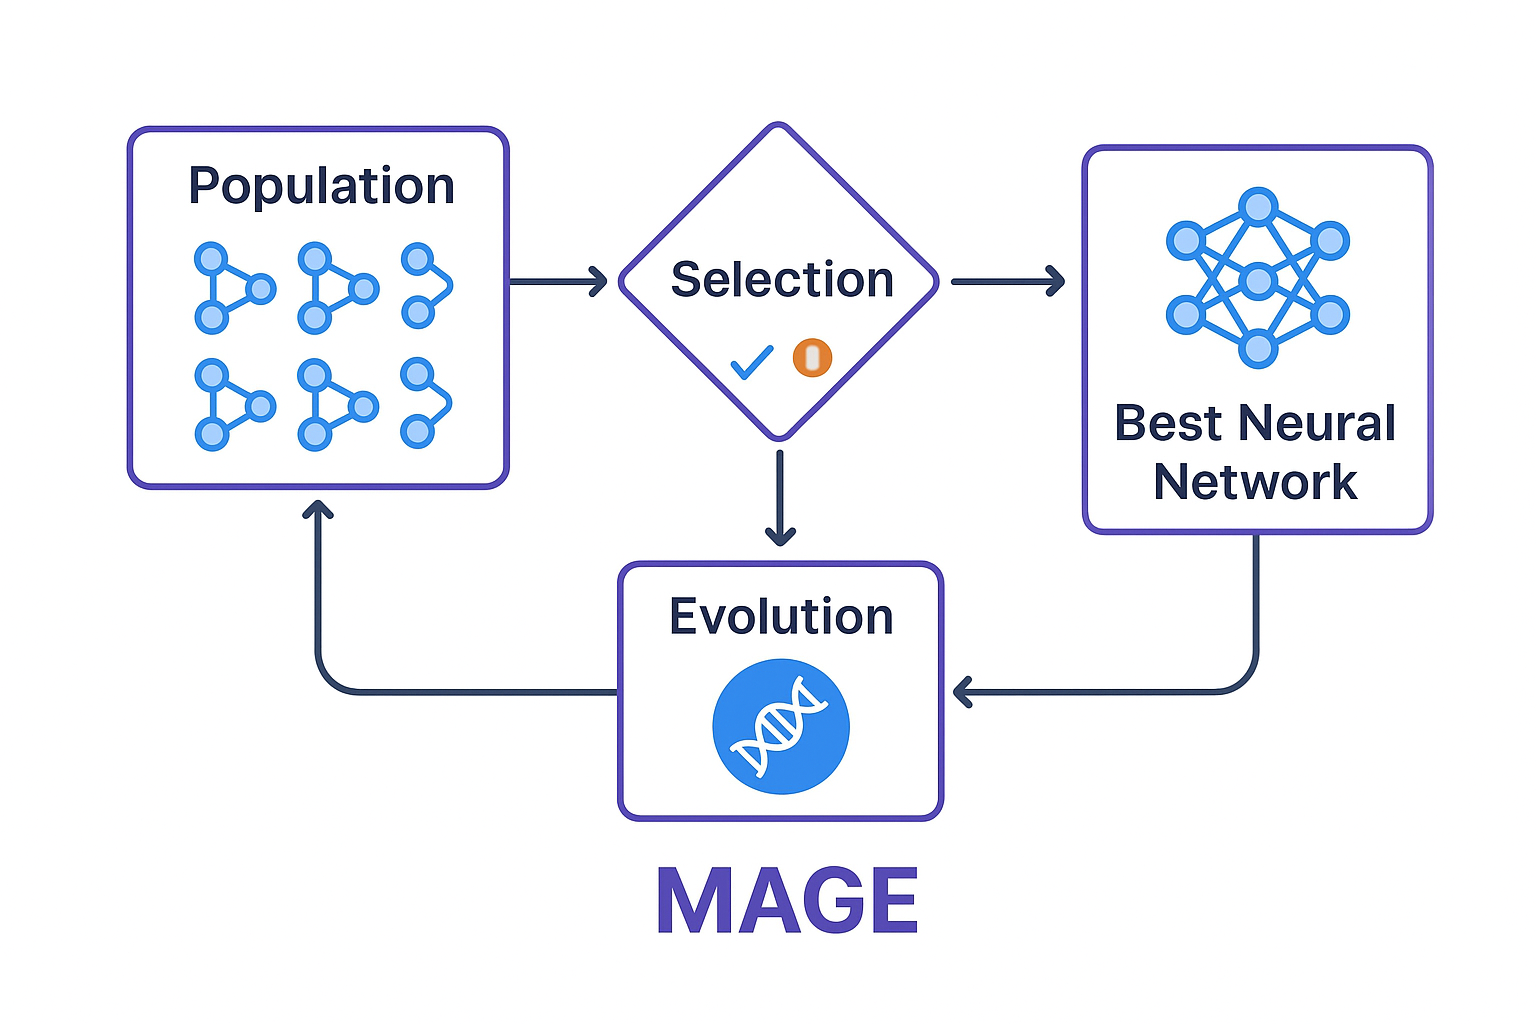